# Fine tuning of Decision Tree Classifier model

## for binary classification

In [1]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score, classification_report,
    ConfusionMatrixDisplay
)

# models
from sklearn.tree import DecisionTreeClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/multiclass'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 24)
(2026, 24)
(8103,)
(2026,)


In [3]:
# numeric features that need transformation
real_features = [
    'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp',
    'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope',
    'mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound'
]

# scorer: F1 score
scorer = make_scorer(score_func=f1_score, average='micro')

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

### Tuning without PCA

In [4]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = DecisionTreeClassifier(random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [5]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(
        subset=['param_model__criterion', 'param_model__max_depth', 'param_model__min_samples_split', 'param_model__ccp_alpha'], 
        keep='last'
    )
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for crit in df['param_model__criterion'].unique():
        for ccp in df['param_model__ccp_alpha'].unique():
            print(f'criterion = {crit}  ccp_alpha: {ccp}')
            
            df_p = df[(df['param_model__criterion'] == crit) & (df['param_model__ccp_alpha'] == ccp)]
            data = df_p.pivot_table(index='param_model__min_samples_split', columns='param_model__max_depth', values='mean_test_score', aggfunc=np.max, fill_value=0)
            annot = df_p.pivot_table(index='param_model__min_samples_split', columns='param_model__max_depth', values='rank', aggfunc=np.min, fill_value=0)    

            try:
                sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
                plt.show()
            except:
                pass

In [8]:
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [3, 5, 7, 11, 17],
    'model__min_samples_split': [2, 4, 8],
    'model__ccp_alpha': np.linspace(0, 0.015, 4),
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 8
n_possible_iterations: 5
min_resources_: 400
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 180
n_resources: 400
Fitting 50 folds for each of 180 candidates, totalling 9000 fits
----------
iter: 1
n_candidates: 90
n_resources: 800
Fitting 50 folds for each of 90 candidates, totalling 4500 fits
----------
iter: 2
n_candidates: 45
n_resources: 1600
Fitting 50 folds for each of 45 candidates, totalling 2250 fits
----------
iter: 3
n_candidates: 23
n_resources: 3200
Fitting 50 folds for each of 23 candidates, totalling 1150 fits
----------
iter: 4
n_candidates: 12
n_resources: 6400
Fitting 50 folds for each of 12 candidates, totalling 600 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'log_loss', 'model__max_depth': 11, 'model__min_samples_split': 2}

Best score:
0.9941545763291633

criterion = gini  ccp_alpha: 0.0


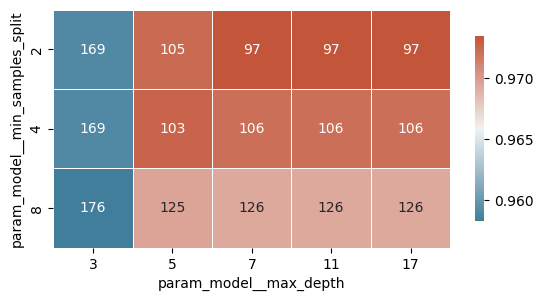

criterion = gini  ccp_alpha: 0.005


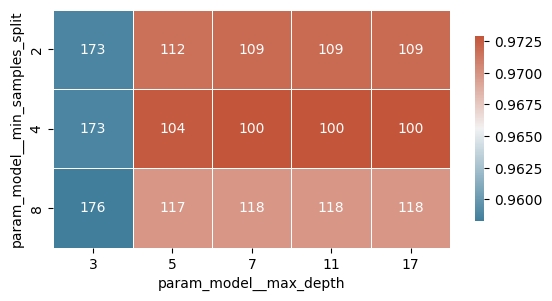

criterion = gini  ccp_alpha: 0.01


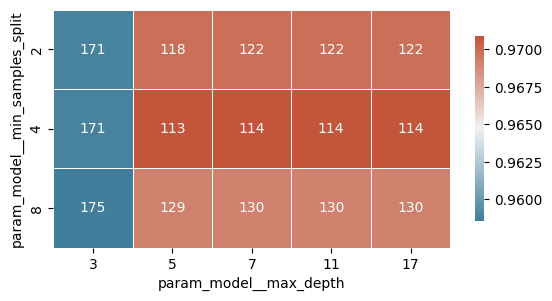

criterion = gini  ccp_alpha: 0.015


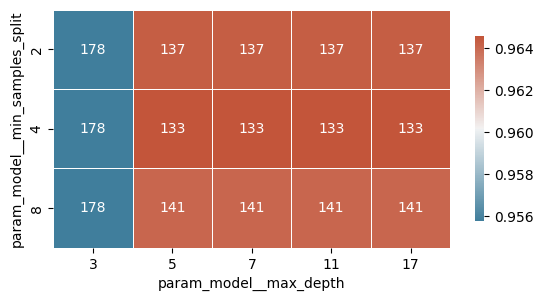

criterion = entropy  ccp_alpha: 0.0


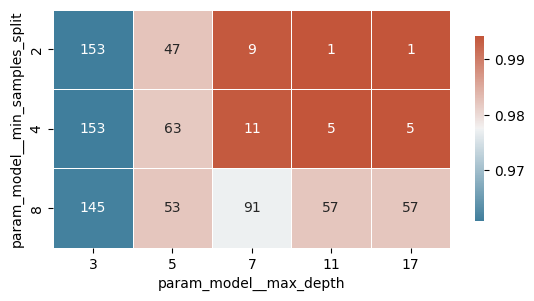

criterion = entropy  ccp_alpha: 0.005


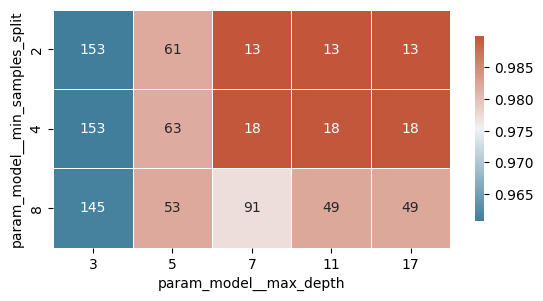

criterion = entropy  ccp_alpha: 0.01


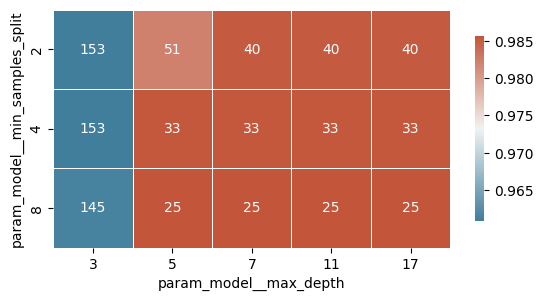

criterion = entropy  ccp_alpha: 0.015


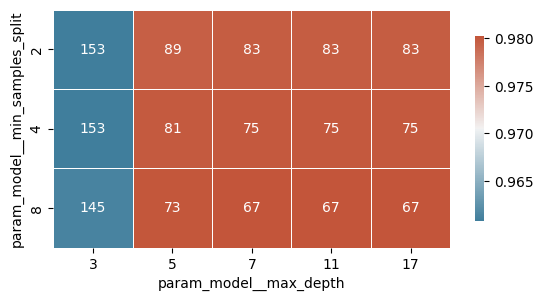

criterion = log_loss  ccp_alpha: 0.0


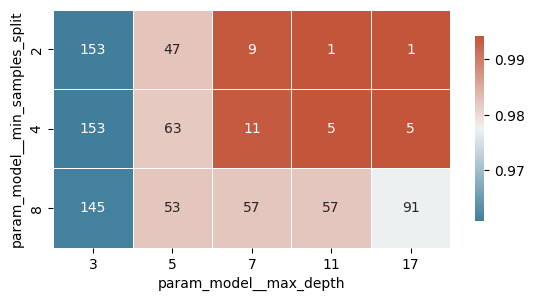

criterion = log_loss  ccp_alpha: 0.005


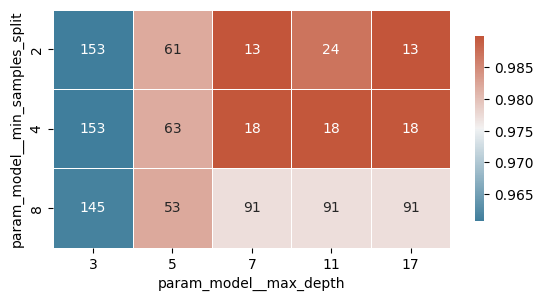

criterion = log_loss  ccp_alpha: 0.01


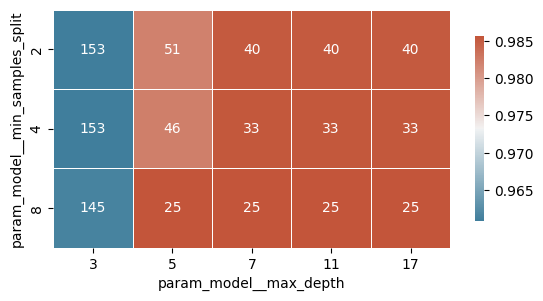

criterion = log_loss  ccp_alpha: 0.015


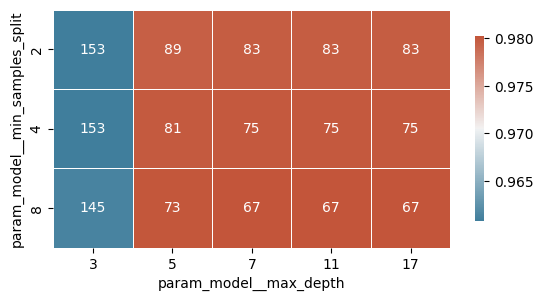

In [9]:
report_results(results)

### Fine-tuning for the most promising region

In [11]:
param_grid = {
    'model__criterion': ['entropy', 'log_loss'],
    'model__max_depth': [7, 9, 11, 13, 15, 17],
    'model__min_samples_split': [2, 3, 4,],
    'model__ccp_alpha': [0.,]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 400
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 400
Fitting 50 folds for each of 36 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 18
n_resources: 800
Fitting 50 folds for each of 18 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 9
n_resources: 1600
Fitting 50 folds for each of 9 candidates, totalling 450 fits
----------
iter: 3
n_candidates: 5
n_resources: 3200
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 4
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'entropy', 'model__max_depth': 15, 'model__min_samples_split': 2}

Best score:
0.994607664679437

criterion = entropy  ccp_alpha: 0.0


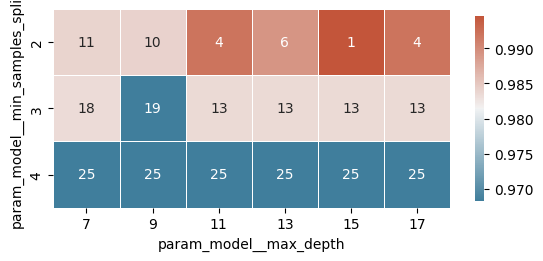

criterion = log_loss  ccp_alpha: 0.0


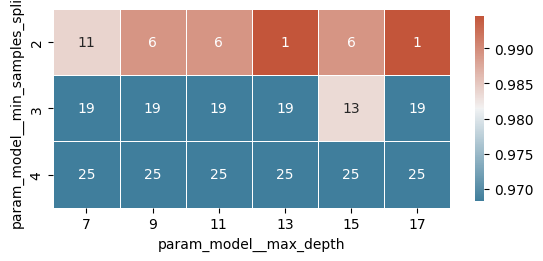

In [12]:
report_results(results)

### Fine-tuning for the most promising region

In [15]:
param_grid = {
    'model__criterion': ['entropy', 'log_loss'],
    'model__max_depth': [13, 14, 15, 16, 17],
    'model__min_samples_split': [2],
    'model__ccp_alpha': [0.,]
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1012
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 1012
Fitting 50 folds for each of 10 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 5
n_resources: 2024
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 2
n_candidates: 3
n_resources: 4048
Fitting 50 folds for each of 3 candidates, totalling 150 fits
----------
iter: 3
n_candidates: 2
n_resources: 8096
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__ccp_alpha': 0.0, 'model__criterion': 'log_loss', 'model__max_depth': 16, 'model__min_samples_split': 2}

Best score:
0.9949585690933758

criterion = entropy  ccp_alpha: 0.0


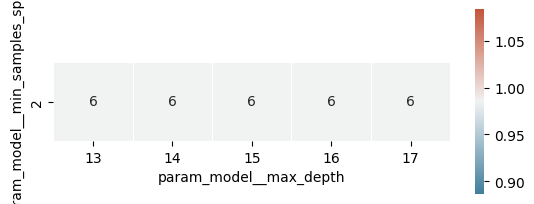

criterion = log_loss  ccp_alpha: 0.0


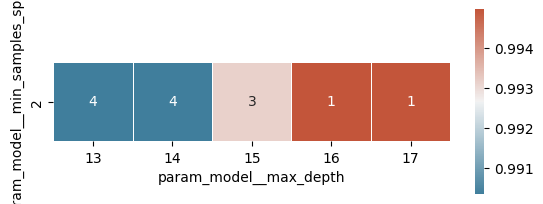

In [16]:
report_results(results)

## Best model cross-validation performance

In [17]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9950
Median: 0.9951
95% confidence interval: (0.9909 - 0.9975)


## Evaluate best model on hold-out test dataset

In [18]:
y_pred = results.best_estimator_.predict(X_test)

In [19]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     1.0000    1.0000    1.0000        92
           2     0.9551    1.0000    0.9770       149
           3     1.0000    0.9424    0.9704       139

    accuracy                         0.9961      2026
   macro avg     0.9886    0.9856    0.9868      2026
weighted avg     0.9962    0.9961    0.9960      2026



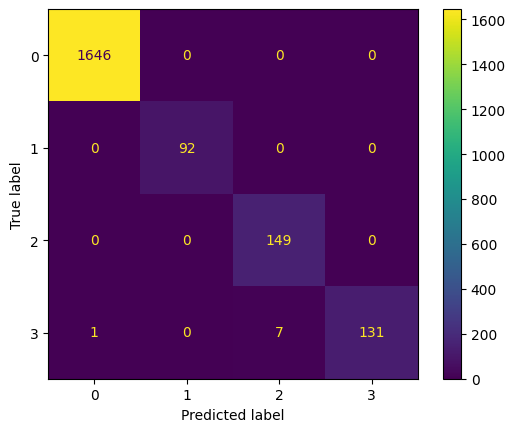

In [20]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()